In [2]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 1.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357258 sha256=6f839362a3d2a0939fc531cc929697f9abc6f928ea715736b8c43b5f8caa6778
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=6e3cee84d03c15eefb3ef78919d3f2bf27616667fa07ce888194a5eef087be1d
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


# **Filtrado Colaborativo basado en Usuario**


In [3]:
import numpy as np
import pandas as pd
from surprise import Dataset, Reader
from surprise import KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import cross_validate

# Cargar el dataset de ejemplo
data = Dataset.load_builtin('ml-100k')

# Dividir el dataset en entrenamiento y prueba
trainset, testset = train_test_split(data, test_size=0.25)

# Definir el algoritmo KNN Básico
sim_options = {
    'name': 'cosine',
    'user_based': True  # Falso para Filtrado Basado en Ítems
}
algo = KNNBasic(sim_options=sim_options)

# Entrenar el modelo
algo.fit(trainset)

# Hacer predicciones
predictions = algo.test(testset)

# Evaluar el modelo
accuracy.rmse(predictions)
accuracy.mae(predictions)

# Validación cruzada
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0208
MAE:  0.8093
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0186  1.0208  1.0151  1.0178  1.0164  1.0177  0.0019  
MAE (testset)     0.8059  0.8061  0.8022  0.8031  0.8062  0.8047  0.0017  

{'test_rmse': array([1.01863223, 1.02075142, 1.01514275, 1.01779508, 1.01642393]),
 'test_mae': array([0.80593747, 0.8061075 , 0.80217393, 0.80310773, 0.80618584]),
 'fit_time': (0.5324954986572266,
  0.7907063961029053,
  0.5463008880615234,
  0.5520408153533936,
  0.8004543781280518),
 'test_time': (3.1807425022125244,
  3.4299848079681396,
  3.106929302215576,
  3.3497183322906494,
  3.3322651386260986)}

Root-mean-square error = 0.13441133499145508
+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|     0|[{1, 3.7767186}, ...|
|     1|[{1, 3.98333}, {0...|
|     2|[{2, 4.847252}, {...|
|     3|[{3, 2.812537}, {...|
+------+--------------------+



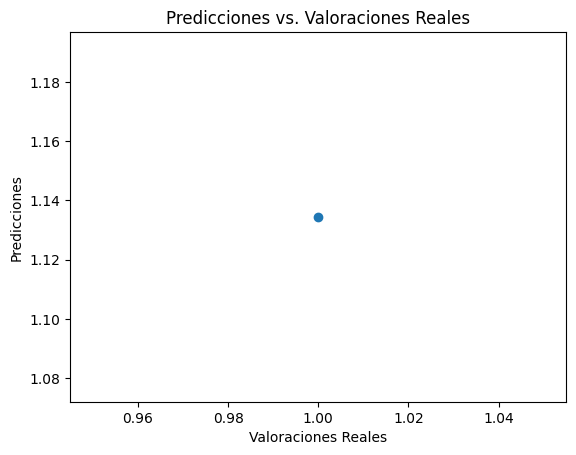

In [6]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import Row
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Crear la sesión de Spark
spark = SparkSession.builder.appName('UserCF').getOrCreate()

# Crear datos de ejemplo
ratings = [
    (0, 0, 3.0), (0, 1, 4.0), (0, 3, 1.0),
    (1, 0, 4.0), (1, 2, 2.0), (1, 3, 1.0),
    (2, 1, 2.0), (2, 2, 5.0),
    (3, 0, 1.0), (3, 3, 3.0)
]

ratings_df = spark.createDataFrame(ratings, ["userId", "itemId", "rating"])

# Dividir el dataset en entrenamiento y prueba
(training, test) = ratings_df.randomSplit([0.75, 0.25])

# Crear y entrenar el modelo ALS
als = ALS(maxIter=10, regParam=0.1, userCol="userId", itemCol="itemId", ratingCol="rating", coldStartStrategy="drop")
model = als.fit(training)

# Realizar predicciones
predictions = model.transform(test)

# Evaluar el modelo
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")

# Mostrar las recomendaciones para todos los usuarios
user_recs = model.recommendForAllUsers(3)
user_recs.show()

# Gráfico de Predicciones vs. Valoraciones Reales
predictions_pd = predictions.toPandas()
plt.scatter(predictions_pd['rating'], predictions_pd['prediction'])
plt.xlabel('Valoraciones Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs. Valoraciones Reales')
plt.show()

# **Filtrado Colaborativo basado en Items**

In [7]:
import numpy as np
import pandas as pd
from surprise import Dataset, Reader
from surprise import KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import cross_validate

# Cargar el dataset de ejemplo
data = Dataset.load_builtin('ml-100k')

# Dividir el dataset en entrenamiento y prueba
trainset, testset = train_test_split(data, test_size=0.25)

# Definir el algoritmo KNN Básico
sim_options = {
    'name': 'cosine',
    'user_based': False  # True para Filtrado Basado en Usuarios
}
algo = KNNBasic(sim_options=sim_options)

# Entrenar el modelo
algo.fit(trainset)

# Hacer predicciones
predictions = algo.test(testset)

# Evaluar el modelo
accuracy.rmse(predictions)
accuracy.mae(predictions)

# Validación cruzada
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0362
MAE:  0.8190
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0231  1.0332  1.0332  1.0185  1.0251  1.0266  0.0058  
MAE (testset)     0.8119  0.8170  0.8148  0.8058  0.8094  0.8118  0.0040  
Fit time          1.05    0.88    1.19    1.31    0.80    1.05    0.19    
Test time         3.62    4.72    5.35    7.58    3.73    5.00    1.44    


{'test_rmse': array([1.02313332, 1.03319787, 1.03319622, 1.0184856 , 1.02507482]),
 'test_mae': array([0.81190034, 0.81704336, 0.81478119, 0.80576079, 0.80935964]),
 'fit_time': (1.048368215560913,
  0.8827106952667236,
  1.1935293674468994,
  1.3076796531677246,
  0.7982709407806396),
 'test_time': (3.623648166656494,
  4.717093229293823,
  5.3452467918396,
  7.581142425537109,
  3.7316250801086426)}

Root-mean-square error = 3.1452657553345613
+------+--------------------+
|itemId|     recommendations|
+------+--------------------+
|     0|[{3, 0.89986247},...|
|     1|[{0, 3.831168}, {...|
|     2|[{2, 4.8549547}, ...|
|     3|[{2, 1.3501953}, ...|
+------+--------------------+



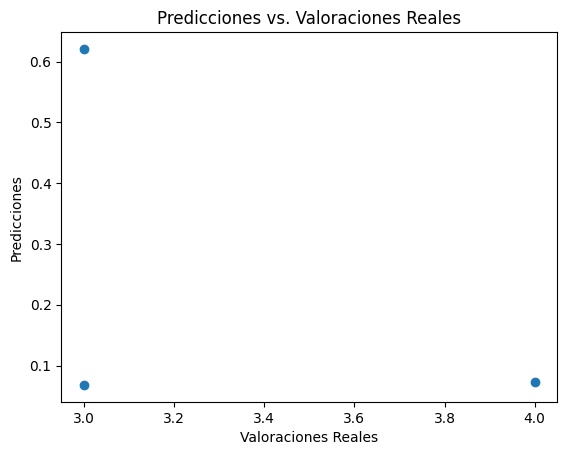

In [8]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import Row
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Crear la sesión de Spark
spark = SparkSession.builder.appName('ItemCF').getOrCreate()

# Crear datos de ejemplo
ratings = [
    (0, 0, 3.0), (0, 1, 4.0), (0, 3, 1.0),
    (1, 0, 4.0), (1, 2, 2.0), (1, 3, 1.0),
    (2, 1, 2.0), (2, 2, 5.0),
    (3, 0, 1.0), (3, 3, 3.0)
]

ratings_df = spark.createDataFrame(ratings, ["userId", "itemId", "rating"])

# Dividir el dataset en entrenamiento y prueba
(training, test) = ratings_df.randomSplit([0.75, 0.25])

# Crear y entrenar el modelo ALS
als = ALS(maxIter=10, regParam=0.1, userCol="userId", itemCol="itemId", ratingCol="rating", coldStartStrategy="drop")
model = als.fit(training)

# Realizar predicciones
predictions = model.transform(test)

# Evaluar el modelo
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")

# Mostrar las recomendaciones para todos los usuarios
item_recs = model.recommendForAllItems(3)
item_recs.show()

# Gráfico de Predicciones vs. Valoraciones Reales
predictions_pd = predictions.toPandas()
plt.scatter(predictions_pd['rating'], predictions_pd['prediction'])
plt.xlabel('Valoraciones Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs. Valoraciones Reales')
plt.show()

In [9]:
import numpy as np
import pandas as pd
from surprise import Dataset, Reader
from surprise import KNNBasic
from surprise.model_selection import cross_validate
import plotly.graph_objects as go

# Cargar el dataset de ejemplo
data = Dataset.load_builtin('ml-100k')

# Definir el algoritmo KNN Básico
sim_options = {
    'name': 'cosine',
    'user_based': False  # True para Filtrado Basado en Usuarios
}
algo = KNNBasic(sim_options=sim_options)

# Validación cruzada
results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Gráficos de resultados
rmse_scores = results['test_rmse']
mae_scores = results['test_mae']

fig = go.Figure()
fig.add_trace(go.Scatter(y=rmse_scores, mode='lines+markers', name='RMSE'))
fig.add_trace(go.Scatter(y=mae_scores, mode='lines+markers', name='MAE'))
fig.update_layout(title='Resultados de Validación Cruzada',
                  xaxis_title='Fold',
                  yaxis_title='Score',
                  showlegend=True)
fig.show()

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0264  1.0221  1.0373  1.0247  1.0186  1.0258  0.0063  
MAE (testset)     0.8100  0.8084  0.8197  0.8120  0.8061  0.8112  0.0047  
Fit time          0.93    0.79    0.80    1.10    0.81    0.89    0.12    
Test time         4.84    3.67    3.81    4.59    3.89    4.16    0.46    


# **Filtrado de Contenido (Content-Based Filtering)**

In [14]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import plotly.graph_objects as go

# Crear dataset de ejemplo
data = {
    'item_id': [1, 2, 3, 4, 5],
    'item_description': [
        'This is a book about machine learning.',
        'A deep dive into artificial intelligence.',
        'Learn about data science and machine learning.',
        'Introduction to deep learning techniques.',
        'Machine learning with Python.'
    ],
    'user_rating': [5, 4, 4, 5, 3]
}
df = pd.DataFrame(data)

# Vectorizar las descripciones de los ítems
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['item_description'])

# Crear perfil del usuario
user_profile = tfidf_matrix.T.dot(df['user_rating']).reshape(1, -1)

# Calcular similitud del perfil del usuario con los ítems
user_similarities = cosine_similarity(user_profile, tfidf_matrix).flatten()

# Generar recomendaciones
recommendations = np.argsort(user_similarities)[::-1]

# Mostrar recomendaciones
print("Recomendaciones para el usuario:")
for idx in recommendations:
    print(f"Item {df['item_id'].iloc[idx]}: {df['item_description'].iloc[idx]} (Similitud: {user_similarities[idx]:.2f})")

# Gráfico de similitudes
fig = go.Figure()
fig.add_trace(go.Bar(x=df['item_id'], y=user_similarities, text=df['item_description'], marker_color='blue'))
fig.update_layout(title='Similitud del Perfil del Usuario con los Ítems', xaxis_title='Item ID', yaxis_title='Similitud')
fig.show()

Recomendaciones para el usuario:
Item 1: This is a book about machine learning. (Similitud: 0.63)
Item 4: Introduction to deep learning techniques. (Similitud: 0.58)
Item 3: Learn about data science and machine learning. (Similitud: 0.56)
Item 5: Machine learning with Python. (Similitud: 0.47)
Item 2: A deep dive into artificial intelligence. (Similitud: 0.42)


In [3]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from pyspark.ml.linalg import DenseVector
import plotly.graph_objects as go

# Crear la sesión de Spark
spark = SparkSession.builder.appName('ContentBasedFiltering').getOrCreate()

# Crear datos de ejemplo
data = [
    (1, 'This is a book about machine learning.', 5),
    (2, 'A deep dive into artificial intelligence.', 4),
    (3, 'Learn about data science and machine learning.', 4),
    (4, 'Introduction to deep learning techniques.', 5),
    (5, 'Machine learning with Python.', 3)
]

df = spark.createDataFrame(data, ["item_id", "item_description", "user_rating"])

# Tokenizar las descripciones de los ítems
tokenizer = Tokenizer(inputCol="item_description", outputCol="words")
wordsData = tokenizer.transform(df)

# Calcular TF-IDF
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures")
featurizedData = hashingTF.transform(wordsData)
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

# Crear perfil del usuario
user_profile = rescaledData.select('features', 'user_rating') \
    .rdd.map(lambda x: x['features'] * x['user_rating']) \
    .reduce(lambda x, y: x + y)

# Calcular similitud del perfil del usuario con los ítems
def cosine_similarity(v1, v2):
    return float(v1.dot(v2)) / (v1.norm(2) * v2.norm(2))

cosine_similarity_udf = udf(cosine_similarity, FloatType())
similarities = rescaledData.withColumn("similarity", cosine_similarity_udf(rescaledData['features'], F.lit(DenseVector(user_profile.toArray()))))

# Mostrar recomendaciones
similarities = similarities.orderBy(F.desc("similarity")).select("item_id", "item_description", "similarity").collect()
print("Recomendaciones para el usuario:")
for row in similarities:
    print(f"Item {row['item_id']}: {row['item_description']} (Similitud: {row['similarity']:.2f})")

# Gráfico de similitudes
item_ids = [row['item_id'] for row in similarities]
sim_values = [row['similarity'] for row in similarities]
descriptions = [row['item_description'] for row in similarities]

fig = go.Figure()
fig.add_trace(go.Bar(x=item_ids, y=sim_values, text=descriptions, marker_color='blue'))
fig.update_layout(title='Similitud del Perfil del Usuario con los Ítems', xaxis_title='Item ID', yaxis_title='Similitud')
fig.show()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 1.0 failed 1 times, most recent failure: Lost task 0.0 in stage 1.0 (TID 2) (025807b280c9 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1247, in main
    process()
  File "/usr/local/lib/python3.10/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1239, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/lib/python3.10/dist-packages/pyspark/rdd.py", line 1919, in func
    initial = next(iterator)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 83, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-3-cd154b87150a>", line 35, in <lambda>
TypeError: unsupported operand type(s) for *: 'SparseVector' and 'int'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1049)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2438)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:195)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1247, in main
    process()
  File "/usr/local/lib/python3.10/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1239, in process
    serializer.dump_stream(out_iter, outfile)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/lib/python3.10/dist-packages/pyspark/rdd.py", line 1919, in func
    initial = next(iterator)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 83, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-3-cd154b87150a>", line 35, in <lambda>
TypeError: unsupported operand type(s) for *: 'SparseVector' and 'int'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:784)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1049)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2438)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
